INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
tag
депрессия                   37639
тревожное р-во              10069
ОКР                          5393
ПРЛ                          5219
БАР                          2962
тревожное р-во/невроз        2217
шизофрения                   2055
паранойя                      905
тревожное р-во/депрессия        1
Name: count, dtype: int64


<Axes: >

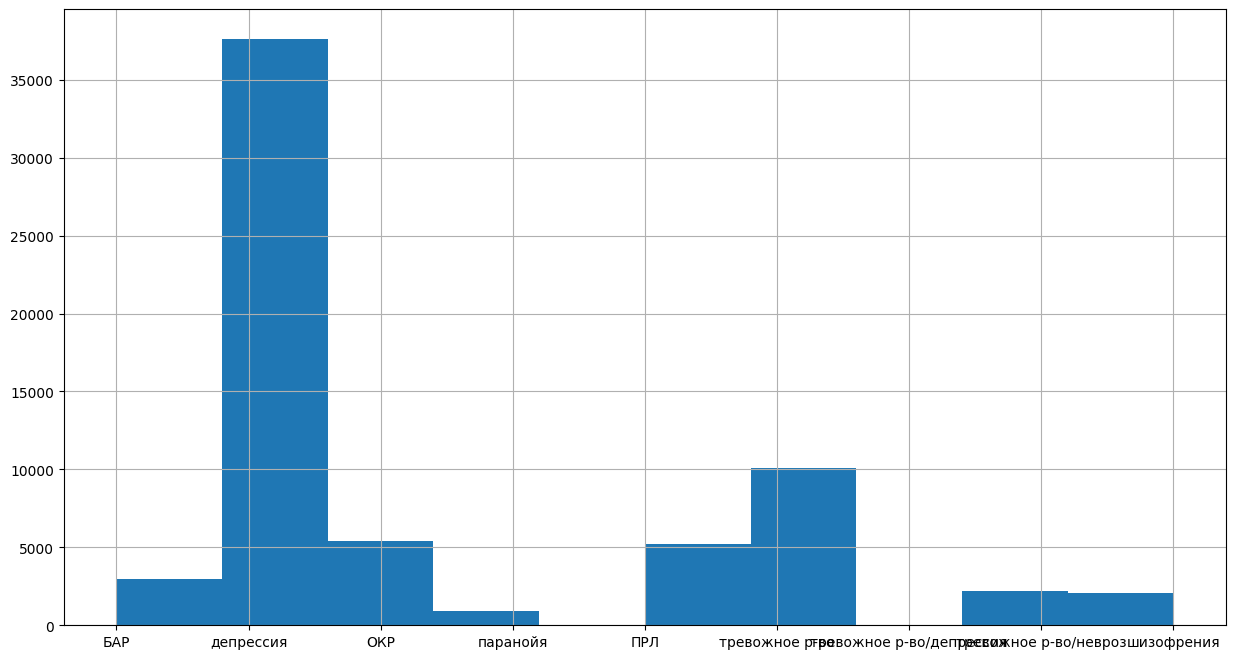

In [1]:
import nltk
import pymorphy3

from pandarallel import pandarallel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import pandas as pd
import numpy as np

dataset = pd.read_csv('Data_Sources_csv.csv',sep=';')

def lemmatize(data, preprocess_column = 'text', n_workers = 16):
    
    import re
    stopwords = nltk.corpus.stopwords.words('russian')
    
    lemma = pymorphy3.MorphAnalyzer()
    data = data.copy()
    data[preprocess_column] = data[preprocess_column].astype(str)
    
    pandarallel.initialize(nb_workers=n_workers)
    data[preprocess_column] = data[preprocess_column].\
                                         parallel_apply(lambda text: re.sub(r'([а-я])([А-Я])', r'\1 \2', text))

    data[preprocess_column] = data[preprocess_column].\
                                         parallel_apply(lambda text: re.sub(r'[^А-Яа-яЁё]', ' ', text))


    data[preprocess_column] = data[preprocess_column].\
                                         parallel_apply(lambda text: text.lower().split())

    data[preprocess_column] = data[preprocess_column].\
                                         parallel_apply(lambda tokenlist: [lemma.parse(word)[0].normal_form for word in tokenlist if word not in stopwords])

    data[preprocess_column] = data[preprocess_column].\
                                         parallel_apply(lambda tokenlist: ' '.join(tokenlist))

    return data

    
dataset = lemmatize(dataset, 'text')
print(dataset['tag'].value_counts())

dataset['tag'].hist(figsize=(15,8))

In [2]:
dataset = dataset[dataset['tag']!='тревожное р-во/депрессия']
dataset = dataset[dataset['tag']!='паранойя'] 
dataset = dataset[dataset['tag']!='тревожное р-во/невроз'] 

old_class_names = dataset['tag'].unique()
new_calss_names = np.arange(len(old_class_names))

dataset['tag'] = dataset['tag'].replace(old_class_names, new_calss_names)

max_count_class = 3900

def downsampling(dataset,columns, max_count_class):
    unique_values = dataset[columns].unique()
    for un in unique_values:
        class_indices = dataset[dataset[columns] == un].index
        
        if len(class_indices) > max_count_class:
            drop_indices = class_indices[max_count_class:]
            dataset = dataset.drop(drop_indices)
            
    return dataset

C:\Users\yaros\AppData\Local\Temp\ipykernel_6400\1596176493.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['tag'] = dataset['tag'].replace(old_class_names, new_calss_names)


In [3]:
dataset.drop(columns=['date'],inplace=True)
dummies_source = pd.get_dummies(dataset['source'],dtype = int)
dataset.drop(columns=['source'],inplace=True)
dataset = pd.concat([dataset, dummies_source],axis=1)
dataset = downsampling(dataset, 'tag', max_count_class)
dataset.dropna(inplace=True)
dataset= dataset.drop_duplicates()
dataset['tag'].value_counts()

tag
3    3886
1    3884
4    3832
2    3645
0    2783
5    2036
Name: count, dtype: int64

In [4]:
X = dataset[['url', 'text', 'forum b17', 'reddit', 'ВК']]
y = dataset['tag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 42,
                                                    )
X_train_txt = X_train['text']
X_test_txt = X_test['text']

X_train_url = X_train['url']
X_test_url = X_test['url']

vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features = 31000)
X_train_txt = vectorizer.fit_transform(X_train_txt)
X_test_txt = vectorizer.transform(X_test_txt)

url_vectorizer = CountVectorizer(max_features=1000)
X_train_url = url_vectorizer.fit_transform(X_train_url)
X_test_url = url_vectorizer.transform(X_test_url)

X_train = np.hstack((X_train_txt.toarray(), X_train[['forum b17', 'reddit', 'ВК']]))
X_test = np.hstack((X_test_txt.toarray(), X_test[['forum b17','reddit', 'ВК']]))

X_train = np.hstack((X_train_url.toarray(), X_train) )
X_test = np.hstack((X_test_url.toarray() , X_test))

In [5]:
from sklearn.metrics import classification_report, f1_score
from sklearn.naive_bayes import (ComplementNB, MultinomialNB,
                                GaussianNB)

In [6]:
model = ComplementNB()

model.fit(X_train, y_train)

predict = model.predict(X_test)

print(f1_score(y_test, predict, average='macro'))
print(classification_report(y_test, predict))

0.7954322992738089
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       530
           1       0.49      1.00      0.66       791
           2       1.00      0.71      0.83       757
           3       1.00      0.86      0.92       775
           4       1.00      0.72      0.84       780
           5       0.86      0.48      0.62       381

    accuracy                           0.79      4014
   macro avg       0.89      0.77      0.80      4014
weighted avg       0.89      0.79      0.81      4014



In [7]:
model = MultinomialNB()

model.fit(X_train, y_train)

predict = model.predict(X_test)

print(f1_score(y_test, predict, average='macro'))
print(classification_report(y_test, predict))

0.7645003046590243
              precision    recall  f1-score   support

           0       1.00      0.79      0.89       530
           1       0.47      1.00      0.64       791
           2       1.00      0.67      0.81       757
           3       1.00      0.84      0.91       775
           4       1.00      0.71      0.83       780
           5       0.82      0.38      0.52       381

    accuracy                           0.77      4014
   macro avg       0.88      0.73      0.76      4014
weighted avg       0.88      0.77      0.78      4014



In [8]:
model = GaussianNB()

model.fit(X_train, y_train)

predict = model.predict(X_test)

print(f1_score(y_test, predict, average='macro'))
print(classification_report(y_test, predict))

0.7360326815681509
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       530
           1       0.75      0.50      0.60       791
           2       0.82      0.79      0.80       757
           3       0.83      0.89      0.86       775
           4       0.82      0.80      0.81       780
           5       0.46      0.66      0.54       381

    accuracy                           0.75      4014
   macro avg       0.74      0.75      0.74      4014
weighted avg       0.76      0.75      0.75      4014

